In the previous work book , we have explored the data using sql functionality available in pyspark. In this note book , we build
an algorithm on existing features evaluate it's performance.

** Setting up Spark Environment **

In [1]:
from pyspark import SparkConf,SparkContext
from pyspark.sql import SparkSession,SQLContext

In [2]:
spark=SparkSession.builder.master("local[*]").appName("predict-us-income").getOrCreate()
spark

In [3]:
sc=spark.sparkContext
sc

<SparkContext master=local[*] appName=predict-us-income>

In [4]:
sqlcontext=SQLContext(spark.sparkContext)
sqlcontext

** SQL Imports **

In [5]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import col,udf

** ML Imports **

In [6]:
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator,CrossValidatorModel
from pyspark.ml.feature import Bucketizer,StringIndexer,OneHotEncoder,StandardScaler,VectorAssembler
from pyspark.ml import Pipeline,PipelineModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator

**MLlib Imports** 

In [7]:
from pyspark.mllib.evaluation import MulticlassMetrics

** Python Imports **

In [8]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
np.random.seed=42
np.random.set_state=42

In [9]:
schema=StructType([StructField("age",IntegerType(),nullable=True),
                   StructField("workclass",StringType(),nullable=True),
                   StructField("fnlgwt",IntegerType(),nullable=True),
                   StructField("education",StringType(),nullable=True),
                   StructField("education_num",IntegerType(),nullable=True),
                   StructField("marital_status",StringType(),nullable=True),
                   StructField("occupation",StringType(),nullable=True),
                   StructField("relationship",StringType(),nullable=True),
                   StructField("race",StringType(),nullable=True),
                   StructField("sex",StringType(),nullable=True),
                   StructField("capital_gain",DoubleType(),nullable=True),
                   StructField("capital_loss",DoubleType(),nullable=True),
                   StructField("hours_per_week",DoubleType(),nullable=True),
                   StructField("native_country",StringType(),nullable=True),
                   StructField("income",StringType(),nullable=True)])

In [10]:
df=spark.read.csv(path='Train.csv',schema=schema,ignoreLeadingWhiteSpace=True,ignoreTrailingWhiteSpace=True).cache()

In [11]:
df.limit(10).toPandas().head()

,age,workclass,fnlgwt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


** Missing values in each column **

In [12]:
for k in df.columns:
    Num_Nulls=df.filter(df[k].isNull()).count()
    print("Column: %s  Nulls: %d"%(k,Num_Nulls))

Column: age  Nulls: 0
Column: workclass  Nulls: 0
Column: fnlgwt  Nulls: 0
Column: education  Nulls: 0
Column: education_num  Nulls: 0
Column: marital_status  Nulls: 0
Column: occupation  Nulls: 0
Column: relationship  Nulls: 0
Column: race  Nulls: 0
Column: sex  Nulls: 0
Column: capital_gain  Nulls: 0
Column: capital_loss  Nulls: 0
Column: hours_per_week  Nulls: 0
Column: native_country  Nulls: 0
Column: income  Nulls: 0


None of the columns has any Null values 

In [13]:
df=df.replace(to_replace='?',value='Missing',subset=['workclass','occupation','native_country'])

In [14]:
list_categoricals=['workclass','education','marital_status','occupation','relationship','race','sex','native_country',]

In [15]:
list_numericals=["age","fnlgwt","education_num","capital_gain","capital_loss","hours_per_week"]

**Converting Categoricals to One Hot encoding **

In [16]:
for column in list_categoricals:
    stringIndexer = StringIndexer(inputCol=column, outputCol="{0}_Indexed".format(column)).fit(df)
    df=stringIndexer.transform(df)
    onehotencode=OneHotEncoder(dropLast=True,inputCol="{0}_Indexed".format(column),outputCol="{0}_HC".format(column))
    df=onehotencode.transform(df)

In [17]:
df.limit(10).toPandas().head()

,age,workclass,fnlgwt,education,education_num,marital_status,occupation,relationship,race,sex,...,occupation_Indexed,occupation_HC,relationship_Indexed,relationship_HC,race_Indexed,race_HC,sex_Indexed,sex_HC,native_country_Indexed,native_country_HC
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,...,3.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0)",0.0,(1.0),0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,...,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0)",0.0,(1.0),0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,...,9.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0)",0.0,(1.0),0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,...,9.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0)",0.0,(1.0),0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,...,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.0,"(0.0, 0.0, 0.0, 0.0, 1.0)",1.0,"(0.0, 1.0, 0.0, 0.0)",1.0,(0.0),9.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [18]:
vectorassembler=VectorAssembler(inputCols=list_numericals,outputCol="Numeric_feat")
df=vectorassembler.transform(df)
standardscaler=StandardScaler(withMean=True,inputCol="Numeric_feat",outputCol="Numeric_scaled").fit(df)
df=standardscaler.transform(df)   

In [19]:
df.select("Numeric_scaled").limit(10).toPandas().head(10)

,Numeric_scaled
0,"[0.03067008637999638, -1.0635944124434717, 1.1..."
1,"[0.8370961257882483, -1.0086915112165824, 1.13..."
2,"[-0.04264137174802653, 0.24507474139090998, -0..."
3,"[1.057030500172317, 0.4257948174742433, -1.197..."
4,"[-0.7757559530282556, 1.4081540965792847, 1.13..."
5,"[-0.11595282987604943, 0.8981871484619803, 1.5..."
6,"[0.7637846676602255, -0.28035407640754784, -1...."
7,"[0.9837190420442942, 0.1881917355296081, -0.42..."
8,"[-0.5558215786441869, -1.3642576687739874, 1.5..."
9,"[0.2506044607640651, -0.28734602482953997, 1.1..."


**Converting Income column to Labels** 

In [20]:
stringindexer=StringIndexer(inputCol="income",outputCol="label").fit(df)
df=stringindexer.transform(df)

In [21]:
df.select("label").limit(10).toPandas().head()

,label
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


** Adding weight column **

Since, there is a imbalance in the target class, we assign weights to each class. The weightage can be inversely 
proportioanl to the frequency of each class. 

In [22]:
Positive_Weight=np.round(df.filter(df['label']==0).count()/df.count(),2)

In [23]:
df=df.withColumn("Weight",F.when(df['label']==1,Positive_Weight).otherwise(1-Positive_Weight))

In [24]:
df.columns

['age',
 'workclass',
 'fnlgwt',
 'education',
 'education_num',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'native_country',
 'income',
 'workclass_Indexed',
 'workclass_HC',
 'education_Indexed',
 'education_HC',
 'marital_status_Indexed',
 'marital_status_HC',
 'occupation_Indexed',
 'occupation_HC',
 'relationship_Indexed',
 'relationship_HC',
 'race_Indexed',
 'race_HC',
 'sex_Indexed',
 'sex_HC',
 'native_country_Indexed',
 'native_country_HC',
 'Numeric_feat',
 'Numeric_scaled',
 'label',
 'Weight']

In [25]:
features=["workclass_HC","education_HC","marital_status_HC",'occupation_HC','relationship_HC','race_HC','sex_HC','native_country_HC','Numeric_scaled']

In [26]:
df=VectorAssembler(inputCols=features,outputCol="Feat_Assembled").transform(df)

In [27]:
df.select("Feat_Assembled","label").show(10,100)

+----------------------------------------------------------------------------------------------------+-----+
|                                                                                      Feat_Assembled|label|
+----------------------------------------------------------------------------------------------------+-----+
|(100,[4,10,24,32,44,48,52,53,94,95,96,97,98,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.03067008637999...|  0.0|
|(100,[1,10,23,31,43,48,52,53,94,95,96,97,98,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.83709612578824...|  0.0|
|(100,[0,8,25,38,44,48,52,53,94,95,96,97,98,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.04264137174802...|  0.0|
|(100,[0,13,23,38,43,49,52,53,94,95,96,97,98,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.05703050017231...|  0.0|
|(100,[0,10,23,29,47,49,62,94,95,96,97,98,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.7757559530282556,1.4...|  0.0|
|(100,[0,11,23,31,47,48,53,94,95,96,97,98,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.11595282987604943,0....|  0.0|
|(100,[0,18,28,34,4

** Class Percentage in Training Data **

In [28]:
df.groupby().mean("label").show()

+------------------+
|        avg(label)|
+------------------+
|0.2408095574460244|
+------------------+



Only 24% of the data is positive class. The ratio of positive to negative is 1:3 . This is border case from balance to imbalance 
.So, we will apply algorithm on both as-is data and with adding weights to the data

** Creating Test and Training Data sets **

In [29]:
df_feat=df.select("Feat_Assembled","label","Weight")

In [30]:
df_valid=df_feat.sampleBy("label",fractions={0:0.25,1:0.25},seed=np.random.seed).cache()
df_train=df_feat.subtract(df_valid).cache()

In [31]:
print("Number of rows in validation set: %d" %df_valid.count())
print("Number of rows in test set: %d" %df_train.count())

Number of rows in validation set: 8272
Number of rows in test set: 24265


In [32]:
df_valid.groupby().mean("label").show()

+-------------------+
|         avg(label)|
+-------------------+
|0.24032882011605416|
+-------------------+



In [33]:
df_train.groupby().mean("label").show()

+-------------------+
|         avg(label)|
+-------------------+
|0.24112919843395839|
+-------------------+



The distribution of each label is same in both training and validation sets.

** Training Logistic Regression Model with out weights **

In [34]:
LR=LogisticRegression(featuresCol='Feat_Assembled',labelCol="label")
model1=LR.fit(df_train)

In [35]:
pred_valid1=model1.transform(df_valid)

In [36]:
pred_valid1.columns

['Feat_Assembled',
 'label',
 'Weight',
 'rawPrediction',
 'probability',
 'prediction']

In [37]:
pred_valid1.select("rawPrediction").limit(10).collect()

[Row(rawPrediction=DenseVector([6.0218, -6.0218])),
 Row(rawPrediction=DenseVector([0.3025, -0.3025])),
 Row(rawPrediction=DenseVector([-0.8244, 0.8244])),
 Row(rawPrediction=DenseVector([0.8496, -0.8496])),
 Row(rawPrediction=DenseVector([1.5589, -1.5589])),
 Row(rawPrediction=DenseVector([1.6642, -1.6642])),
 Row(rawPrediction=DenseVector([-2.0293, 2.0293])),
 Row(rawPrediction=DenseVector([2.7437, -2.7437])),
 Row(rawPrediction=DenseVector([4.9093, -4.9093])),
 Row(rawPrediction=DenseVector([1.5258, -1.5258]))]

Raw predictions are the transformed values of the input parameters, so they can be between -infinity and + infinity

In [38]:
pred_valid1.select("probability").limit(10).collect()

[Row(probability=DenseVector([0.9976, 0.0024])),
 Row(probability=DenseVector([0.5751, 0.4249])),
 Row(probability=DenseVector([0.3048, 0.6952])),
 Row(probability=DenseVector([0.7005, 0.2995])),
 Row(probability=DenseVector([0.8262, 0.1738])),
 Row(probability=DenseVector([0.8408, 0.1592])),
 Row(probability=DenseVector([0.1162, 0.8838])),
 Row(probability=DenseVector([0.9396, 0.0604])),
 Row(probability=DenseVector([0.9927, 0.0073])),
 Row(probability=DenseVector([0.8214, 0.1786]))]

Prediction probability is the softmax of raw probability and all the values in a row adds upto 1

In [39]:
pred_valid1.select("prediction").limit(10).collect()

[Row(prediction=0.0),
 Row(prediction=0.0),
 Row(prediction=1.0),
 Row(prediction=0.0),
 Row(prediction=0.0),
 Row(prediction=0.0),
 Row(prediction=1.0),
 Row(prediction=0.0),
 Row(prediction=0.0),
 Row(prediction=0.0)]

Prediction label is the argmax of Prediction probability 

In [40]:
Auc_evaluator=BinaryClassificationEvaluator(rawPredictionCol="probability",labelCol='label',metricName='areaUnderROC')
AUC=Auc_evaluator.evaluate(pred_valid1)
Accu_evaluator=MulticlassClassificationEvaluator(predictionCol="prediction",labelCol='label',metricName='accuracy')
ACCU=Accu_evaluator.evaluate(pred_valid1)

In [41]:
print("The model with equal weights give %.2f Area Under Curve and %.2f Accuracy"%(AUC,ACCU))

The model with equal weights give 0.91 Area Under Curve and 0.86 Accuracy


** Training Logistic Regression model with weights**

In [42]:
LR2=LogisticRegression(featuresCol='Feat_Assembled',labelCol="label",weightCol="Weight")
model2=LR2.fit(df_train)

In [43]:
pred_valid2=model2.transform(df_valid)

In [44]:
AUC2=Auc_evaluator.evaluate(pred_valid2)
ACCU2=Accu_evaluator.evaluate(pred_valid2)

In [45]:
print(" The model with adjusted weights is gives %.2f Area Under Curve and %.2f Accuracy"%(AUC2,ACCU2))

 The model with adjusted weights is gives 0.91 Area Under Curve and 0.82 Accuracy


The AUC for both models is comparable but the accuracy has reduced . In the second case, we have increased the weightage of positive class and decreased for the negative class. This might have lead to misclassification of the negative class and resulted in reduced accuracy.

** Setting up pipeline** 

In the previous steps we have manually transformed features for setting up machine learning model. We can automate this 
process by setting up a pipeline.

In [46]:
df_train=spark.read.csv(path="Train.csv",schema=schema,ignoreLeadingWhiteSpace=True,ignoreTrailingWhiteSpace=True).cache()

In [47]:
df_train.limit(5).toPandas().head()

,age,workclass,fnlgwt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [48]:
int_feat=['age','fnlgwt','education_num','capital_gain','capital_loss','hours_per_week']
char_feat=['workclass','education','marital_status','occupation','relationship','race','sex','native_country']

In [49]:
string_indexer=[StringIndexer(inputCol=col_name,outputCol="{0}_StringInd".format(col_name),handleInvalid='skip') for col_name in char_feat]

In [50]:
OneHotEnc=[OneHotEncoder(inputCol="{0}_StringInd".format(col_name),outputCol="{0}_Hotenc".format(col_name)) for col_name in char_feat]

In [51]:
Vector_assmb1=VectorAssembler(inputCols=int_feat,outputCol='numeric_feat')
standard_scaler=StandardScaler(inputCol='numeric_feat',outputCol='numeric_scaled',withMean=True)

In [52]:
Label_indexer=StringIndexer(inputCol="income",outputCol="label",handleInvalid='skip')

In [53]:
feature_columns=['workclass_Hotenc','education_Hotenc','marital_status_Hotenc','occupation_Hotenc','relationship_Hotenc','race_Hotenc','sex_Hotenc','native_country_Hotenc']+['numeric_scaled']

In [54]:
feature_columns

['workclass_Hotenc',
 'education_Hotenc',
 'marital_status_Hotenc',
 'occupation_Hotenc',
 'relationship_Hotenc',
 'race_Hotenc',
 'sex_Hotenc',
 'native_country_Hotenc',
 'numeric_scaled']

In [55]:
Vector_assmbl2=VectorAssembler(inputCols=feature_columns,outputCol="features")

In [56]:
LR3=LogisticRegression(featuresCol="features",labelCol="label")

In [57]:
steps=string_indexer+OneHotEnc+[Vector_assmb1,standard_scaler,Label_indexer,Vector_assmbl2,LR3]

In [58]:
pipeline=Pipeline(stages=steps)

In [59]:
steps

[StringIndexer_4115be89e1b10c037151,
 StringIndexer_421d94f4f778fb0bf1e5,
 StringIndexer_47ef85e64acc2dded685,
 StringIndexer_43bd9c61ac0fb1f5cdb5,
 StringIndexer_4b629099d4ad218bedf2,
 StringIndexer_403a8fbb173c8f4fe84d,
 StringIndexer_4a8aac541acaba24064c,
 StringIndexer_4df68c38cd2dbbddfbe0,
 OneHotEncoder_4f59a4a7586906639d0c,
 OneHotEncoder_43f590d2f282df23bb04,
 OneHotEncoder_41a6a74851da08fe9107,
 OneHotEncoder_40d9a2a446c9a24cd1e0,
 OneHotEncoder_4a8c8caa69faa4f0a5a7,
 OneHotEncoder_4921858d01cf626ac711,
 OneHotEncoder_4cc99c85518dcb62c3ac,
 OneHotEncoder_46fe91c6361bf77da840,
 VectorAssembler_4dd8ba818ee797bbc5d8,
 StandardScaler_4e5b9560526a6dd3e9d5,
 StringIndexer_45feae354bd4cad5681b,
 VectorAssembler_404ca0411bbe2aca019f,
 LogisticRegression_47a0b2a39208d37403fa]

In [60]:
parameter_grid=ParamGridBuilder().addGrid(LR3.regParam,[0.1,0.01,0.001]).addGrid(LR3.elasticNetParam,[0.0,0.5,1.0]).build()

In [61]:
eval_pipeline=BinaryClassificationEvaluator(rawPredictionCol='probability',labelCol='label',metricName='areaUnderROC')

In [62]:
crossval=CrossValidator(estimator=pipeline,evaluator=eval_pipeline,estimatorParamMaps=parameter_grid,numFolds=5,seed=np.random.seed)

In [63]:
cvmodel=crossval.fit(df_train)
bestModel=cvmodel.bestModel

In [64]:
params_values=[k.values() for k in parameter_grid]

In [65]:
df_params=pd.DataFrame(params_values,columns=['regParam','elasticNetParam'])
df_params['metric']=cvmodel.avgMetrics

In [66]:
df_params.sort_values("metric",ascending=True,inplace=True)
df_params

,regParam,elasticNetParam,metric
2,0.100,1.0,0.850160
1,0.100,0.5,0.870738
0,0.100,0.0,0.894821
5,0.010,1.0,0.899497
4,0.010,0.5,0.902812
3,0.010,0.0,0.903357
6,0.001,0.0,0.906067
7,0.001,0.5,0.906385
8,0.001,1.0,0.906531


The best parameters:
    regParam:0.001
    elasticNetParam:1.0

In [67]:
best_logistic_model=bestModel.stages[-1]

In [68]:
logistic_results=best_logistic_model.summary

In [69]:
print(logistic_results)

In [70]:
logistic_results.accuracy

0.853075765486318

In [71]:
logistic_results.areaUnderROC

0.9081414069435865

In [72]:
cv_prediction=cvmodel.transform(df_train).cache()

In [73]:
cv_prediction.select("prediction","label").limit(5).show()

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       1.0|  0.0|
+----------+-----+



In [74]:
metrics=MulticlassMetrics(cv_prediction.select("prediction","label").rdd)
metrics.confusionMatrix().toArray()

array([[23074.,  1646.],
       [ 3138.,  4703.]])

This classifier has recall rate of 59% and false positive rate of 6%. Higher recall rate is preferable because we want
to identify as many high income people as possible. Probing the precision recall curve and modifying the Threshold 
probability will help .

** ROC Curves and Thresholding **

In [75]:
df_roc=logistic_results.roc.toPandas()

In [76]:
df_roc.head(10)

,FPR,TPR
0,0.000000,0.000000
1,0.000121,0.042214
2,0.000364,0.082898
3,0.001011,0.122306
4,0.002468,0.159163
5,0.004086,0.195511
6,0.006189,0.230328
7,0.008333,0.265017
8,0.011610,0.296136
9,0.014361,0.328912


In [77]:
df_rth=logistic_results.recallByThreshold.toPandas()

In [78]:
df_rth.head(10)

,threshold,recall
0,1.000000,0.042214
1,0.996249,0.082898
2,0.970939,0.122306
3,0.933834,0.159163
4,0.893124,0.195511
5,0.856651,0.230328
6,0.823210,0.265017
7,0.795308,0.296136
8,0.766815,0.328912
9,0.739969,0.359520


Text(0.5,1,u'Threshold Curve')

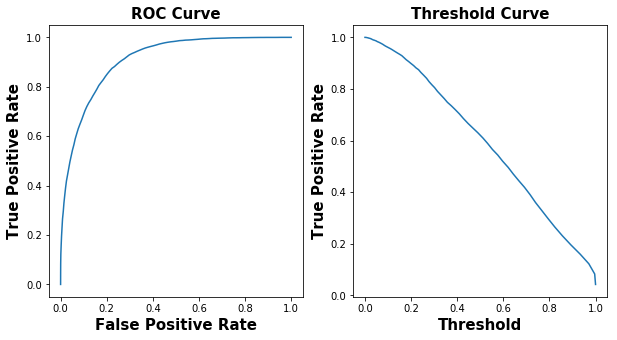

In [80]:
fig1=plt.figure(figsize=(10,5))
ax1=fig1.add_subplot(1,2,1)
ax2=fig1.add_subplot(1,2,2)
ax1.plot(df_roc['FPR'],df_roc['TPR'])
ax1.set_xlabel("False Positive Rate",fontsize=15,weight='bold')
ax1.set_ylabel("True Positive Rate",fontsize=15,weight='bold')
ax1.set_title("ROC Curve",fontsize=15,weight='bold')
ax2.plot(df_rth['threshold'],df_rth['recall'])
ax2.set_xlabel("Threshold",fontsize=15,weight='bold')
ax2.set_ylabel("True Positive Rate",fontsize=15,weight='bold')
ax2.set_title("Threshold Curve",fontsize=15,weight='bold')

In the ROC curve, when the True positive rate is at 0.8 , the False positive rate id 20%. I will take this acceptable 
performance from the classifier. For True positive rate of the threshold is 0.25.

** Model with updated Threshold **

In [81]:
LR3.setThreshold(0.25)

LogisticRegression_47a0b2a39208d37403fa

In [82]:
crossval2=CrossValidator(estimator=pipeline,evaluator=eval_pipeline,estimatorParamMaps=parameter_grid,numFolds=5,seed=np.random.seed)

In [83]:
cvmodel2=crossval2.fit(df_train)
bestModel2=cvmodel2.bestModel

In [84]:
cv_prediction2=cvmodel2.transform(df_train).cache()
metrics2=MulticlassMetrics(cv_prediction2.select("prediction","label").rdd)
metrics2.confusionMatrix().toArray()

array([[19840.,  4880.],
       [ 1212.,  6629.]])

Setting up the threshold to 0.25 has imporved the recall score to 0.84 .This has worsened the precision and False 
positive rate but it is a trade off we can make.

In [86]:
spark.stop()